In [1]:
#########################################################################
# Author: Dan Betea                                                     #
# (C) December 2022                                                     #
# License: CC BY-SA 4.0                                                 #
# License description: https://creativecommons.org/licenses/by-sa/4.0/  #
#########################################################################

# LUE patterns 1: linear regression at the hard edge and beyond

Consider the Laguerre-$\alpha$ Unitary Ensemble (LUE-$\alpha$) distribution on ordered tuples of $N$ positive real numbers $(\lambda_1 < \dots < \lambda_N).$ That is, consider the probability measure

$$P(\lambda_1, \dots, \lambda_N)d \lambda_1 \dots d \lambda_N \propto \prod_{1 \leq i < j \leq N} (\lambda_i - \lambda_j)^2 \prod_{1 \leq i \leq N} \lambda_i^{\alpha-1} e^{-\lambda_i} d \lambda_i$$

where $\alpha > 0$ (notice the somewhat less standard $\alpha$ convention we use for LUE). See [this Wikipedia article](https://en.wikipedia.org/wiki/Complex_Wishart_distribution) for the motivation behind this distribution and how it comes about when studying covariance matrices (see in particular the Eigenvalues section).

We do linear regression on 

$$(\log i, \log E \lambda_i^s)$$

for $i$ in a certain interval like $1, \dots, 10; 1, \dots, \log N$ or more generally $m_0, \dots, m_0 + M - 1$. Here $\lambda_i$ the $i$-th lowest eigenvalue of the LUE-$\alpha$ ensemble and $s$ is a real number, taken negative for convergence. We consider several cases:

- $m_0 = 1, M = 15$, $\alpha = 4, s = -2$, and $N \in \{10000, 5000, 1000\}$
- $m_0 = 1, M \in \{ 100, 1000, 5000, 7500, 9000, 10000\}$, $N=10000$, $\alpha = 4, s = -2$

**Some remarks:**

- in Julia, array indexing starts at 1 by default
- the data files, containing iid samples $(\lambda_1 < \dots < \lambda_N)$, are assumed to be in the same directory as the notebook, and be in the correct format
- most steps below can be automated; for this exploratory notebook they are not
- the plots are displayed as PNGs as Julia's ```Plots``` package has trouble rendering LaTeX in SVG

In [2]:
# some packages we need
using DataFrames          # for dataframes, surely not needed
using GLM                 # for linear regression
using DelimitedFiles      # for reading a big matrix out of a file easily
using Plots               # for plotting 
using LaTeXStrings        # for LaTeX symbols inside plots
using Statistics          # for the obvious reason

## First case: 1000 samples for $\alpha=4, N=10^4$

We fix the parameters and then read the respective file from disk into a large matrix. The parameters manually correspond to the file title. This could be automatized if needed. 

In [3]:
# NOTE: in Julia array indexing starts at 1

alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 15                                       # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×15 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  0.0440713  0.0520729  0.0642741
 0.000779669  0.00120705   0.00350779     0.045964   0.0557982  0.0663039
 0.000400754  0.000852894  0.00203974     0.0476849  0.0534889  0.0678795
 0.000652653  0.00313822   0.00455475     0.0496009  0.054328   0.0644363
 0.000401578  0.00102299   0.00279176     0.0500179  0.056974   0.0622931
 0.000591167  0.00114146   0.00497109  …  0.0525606  0.0576957  0.0639002
 0.0014827    0.00237106   0.00476994     0.0500062  0.0560945  0.0627873
 0.000964205  0.00234669   0.0045921      0.050865   0.0602013  0.0715133
 0.000773585  0.00163975   0.0034974      0.0511637  0.0562713  0.0588947
 0.00111742   0.00230499   0.00401473     0.0470862  0.0499858  0.0614822
 0.00127158   0.00217043   0.00601826  …  0.0505142  0.0595479  0.065659
 0.000903169  0.00180299   0.00408361     0.0472124  0.0543192  0.0609352
 0.00108514   0.00306227   0.00422113     0.0438383  0.0535949  0.0607395
 ⋮            

Note in the above that each line is an iid sample, each column an eigenvalue: the lowest eigenvalues $\lambda_1$ are in column 1, all the $\lambda_2$'s in column 2, etc.

In [4]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];

We fit the regression (linear model), using the ```DataFrames``` and ```GLM``` packages. We also print the summary and the $R^2$ coefficient.

In [5]:
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  15.1817    0.0356488   425.87    <1e-27   15.1047    15.2587
X            -3.53214   0.0177576  -198.91    <1e-23   -3.57051   -3.49378
──────────────────────────────────────────────────────────────────────────

R squared is: 0.9996715306706269


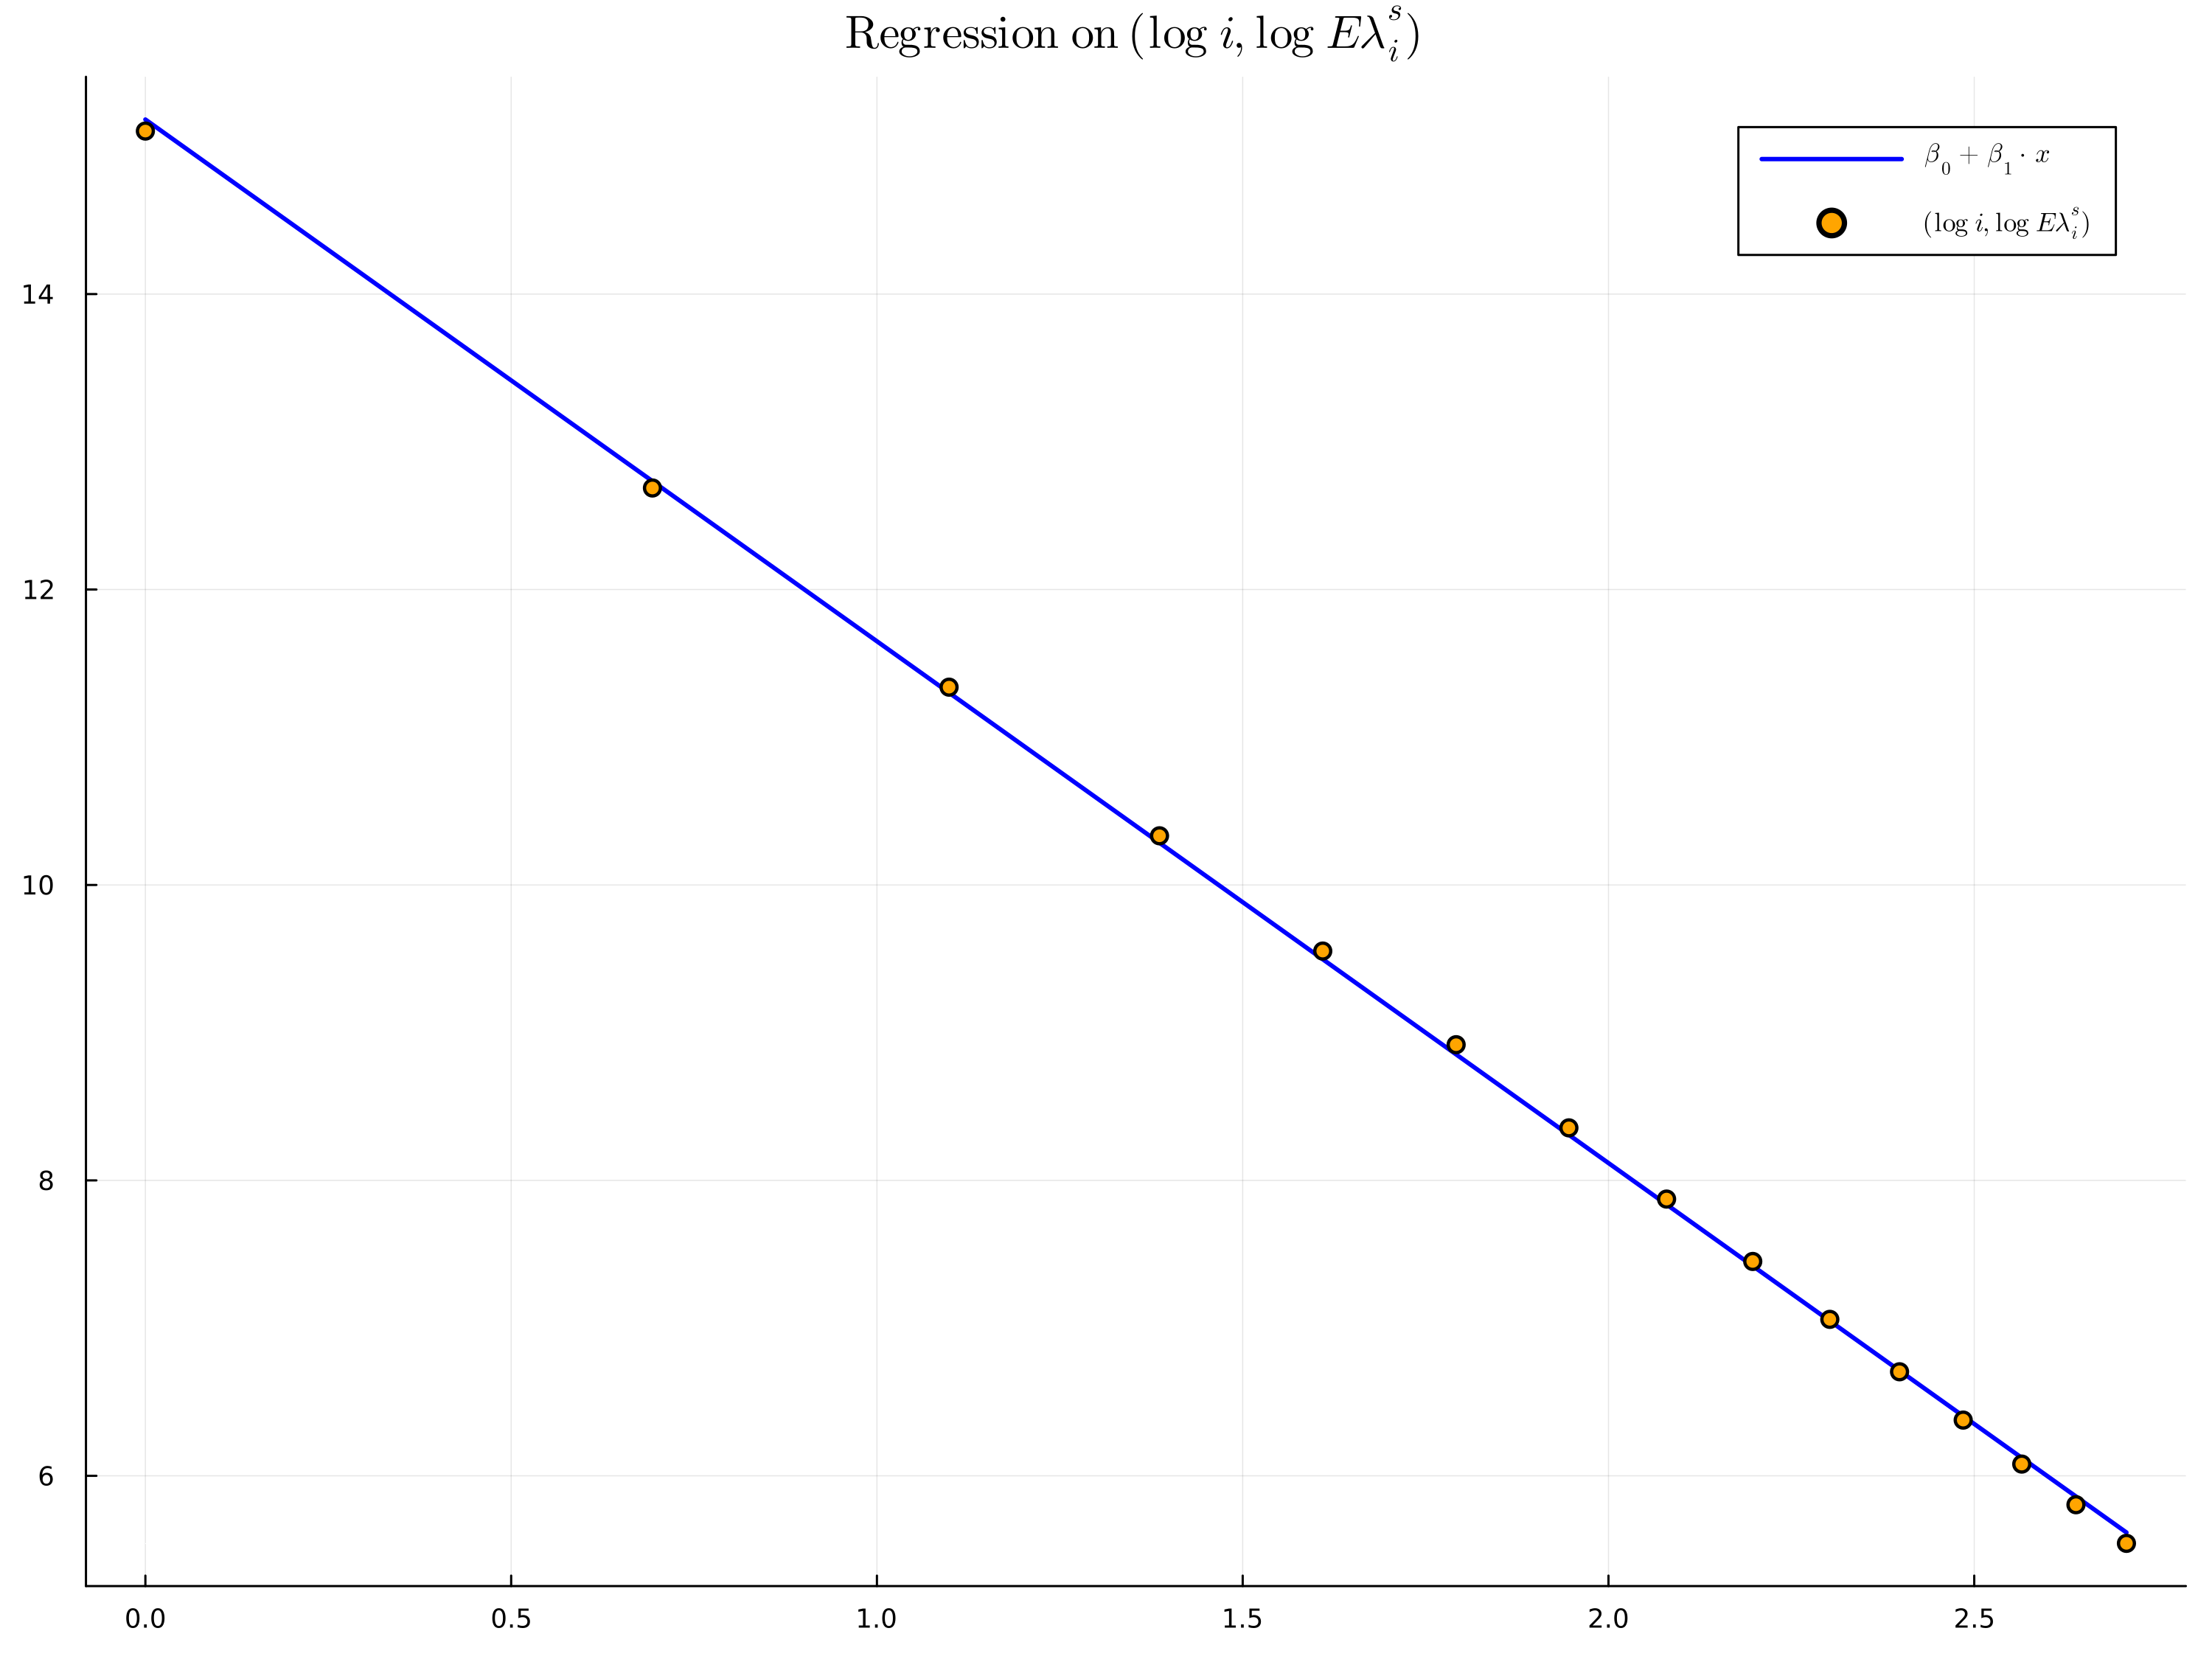

In [6]:
b0, b1 = coef(reg)[1], coef(reg)[2]     # extract regression intercept and slope
start_x, end_x = log(m0), log(m0+M-1)   # extract start and end of regression line too

# plot the scatter data and the regression line
x = range(start_x, end_x, length=1000)
y = @. b0 .+ b1 .* x
plot(x, y, label=L"\beta_0 + \beta_1 \cdot x", lw=2, lc=:blue, fmt = :png, dpi=300, size=(1000,750))
# next line: ugly hack for legend spacing
scatter!([minimum(log_ms)],[minimum(log_expectations)], label=" ", ms=0, mc=:white, msc=:white) 
plot!(log_ms, log_expectations, seriestype=:scatter, label=L"(\log\ i, \log\ E \lambda_i^s)", c=:orange)
title!(L"\mathrm{Regression\ on\ } (\log\ i, \log\ E \lambda_i^s)")

## Second case: 1000 samples for $\alpha=4, N=5000$

Same as before, but with $N=5000$, half the size. While the file contains 2000 samples, we only look at 1000 of them to compare with the $N=10^4$ case.

In [7]:
# NOTE: in Julia array indexing starts at 1

alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 5000                                     # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 15                                       # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×15 Matrix{Float64}:
 0.00114      0.00280814  0.00431431  …  0.0926519  0.116086  0.11825
 0.00111132   0.00349919  0.0055273      0.101648   0.115966  0.132662
 0.000432308  0.00354626  0.00623526     0.105067   0.110928  0.122063
 0.000498947  0.0034942   0.00772856     0.103869   0.119678  0.133421
 0.00205988   0.00457355  0.00901283     0.0914804  0.101794  0.122118
 0.000843797  0.00212879  0.00713236  …  0.0982175  0.112502  0.122828
 0.00224416   0.00321881  0.00557435     0.103617   0.118349  0.130168
 0.000455726  0.00148179  0.00293174     0.0943008  0.106221  0.121311
 0.00160361   0.00605534  0.00936403     0.0893618  0.106661  0.118447
 0.00146437   0.00330407  0.00596102     0.0909815  0.10592   0.1201
 0.00130039   0.00367122  0.00801006  …  0.10767    0.122501  0.137653
 0.00175824   0.00436859  0.00986956     0.0936812  0.111406  0.125233
 0.00147516   0.00235624  0.00371474     0.0881306  0.105292  0.121216
 ⋮                                    ⋱                

We use the same values as before for $s$, do the exact same regression as well.

In [8]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  13.7713    0.0377006   365.28    <1e-26   13.6898    13.8527
X            -3.52061   0.0187797  -187.47    <1e-22   -3.56118   -3.48004
──────────────────────────────────────────────────────────────────────────

R squared is: 0.9996302367539628


Let us plot the data and the line.

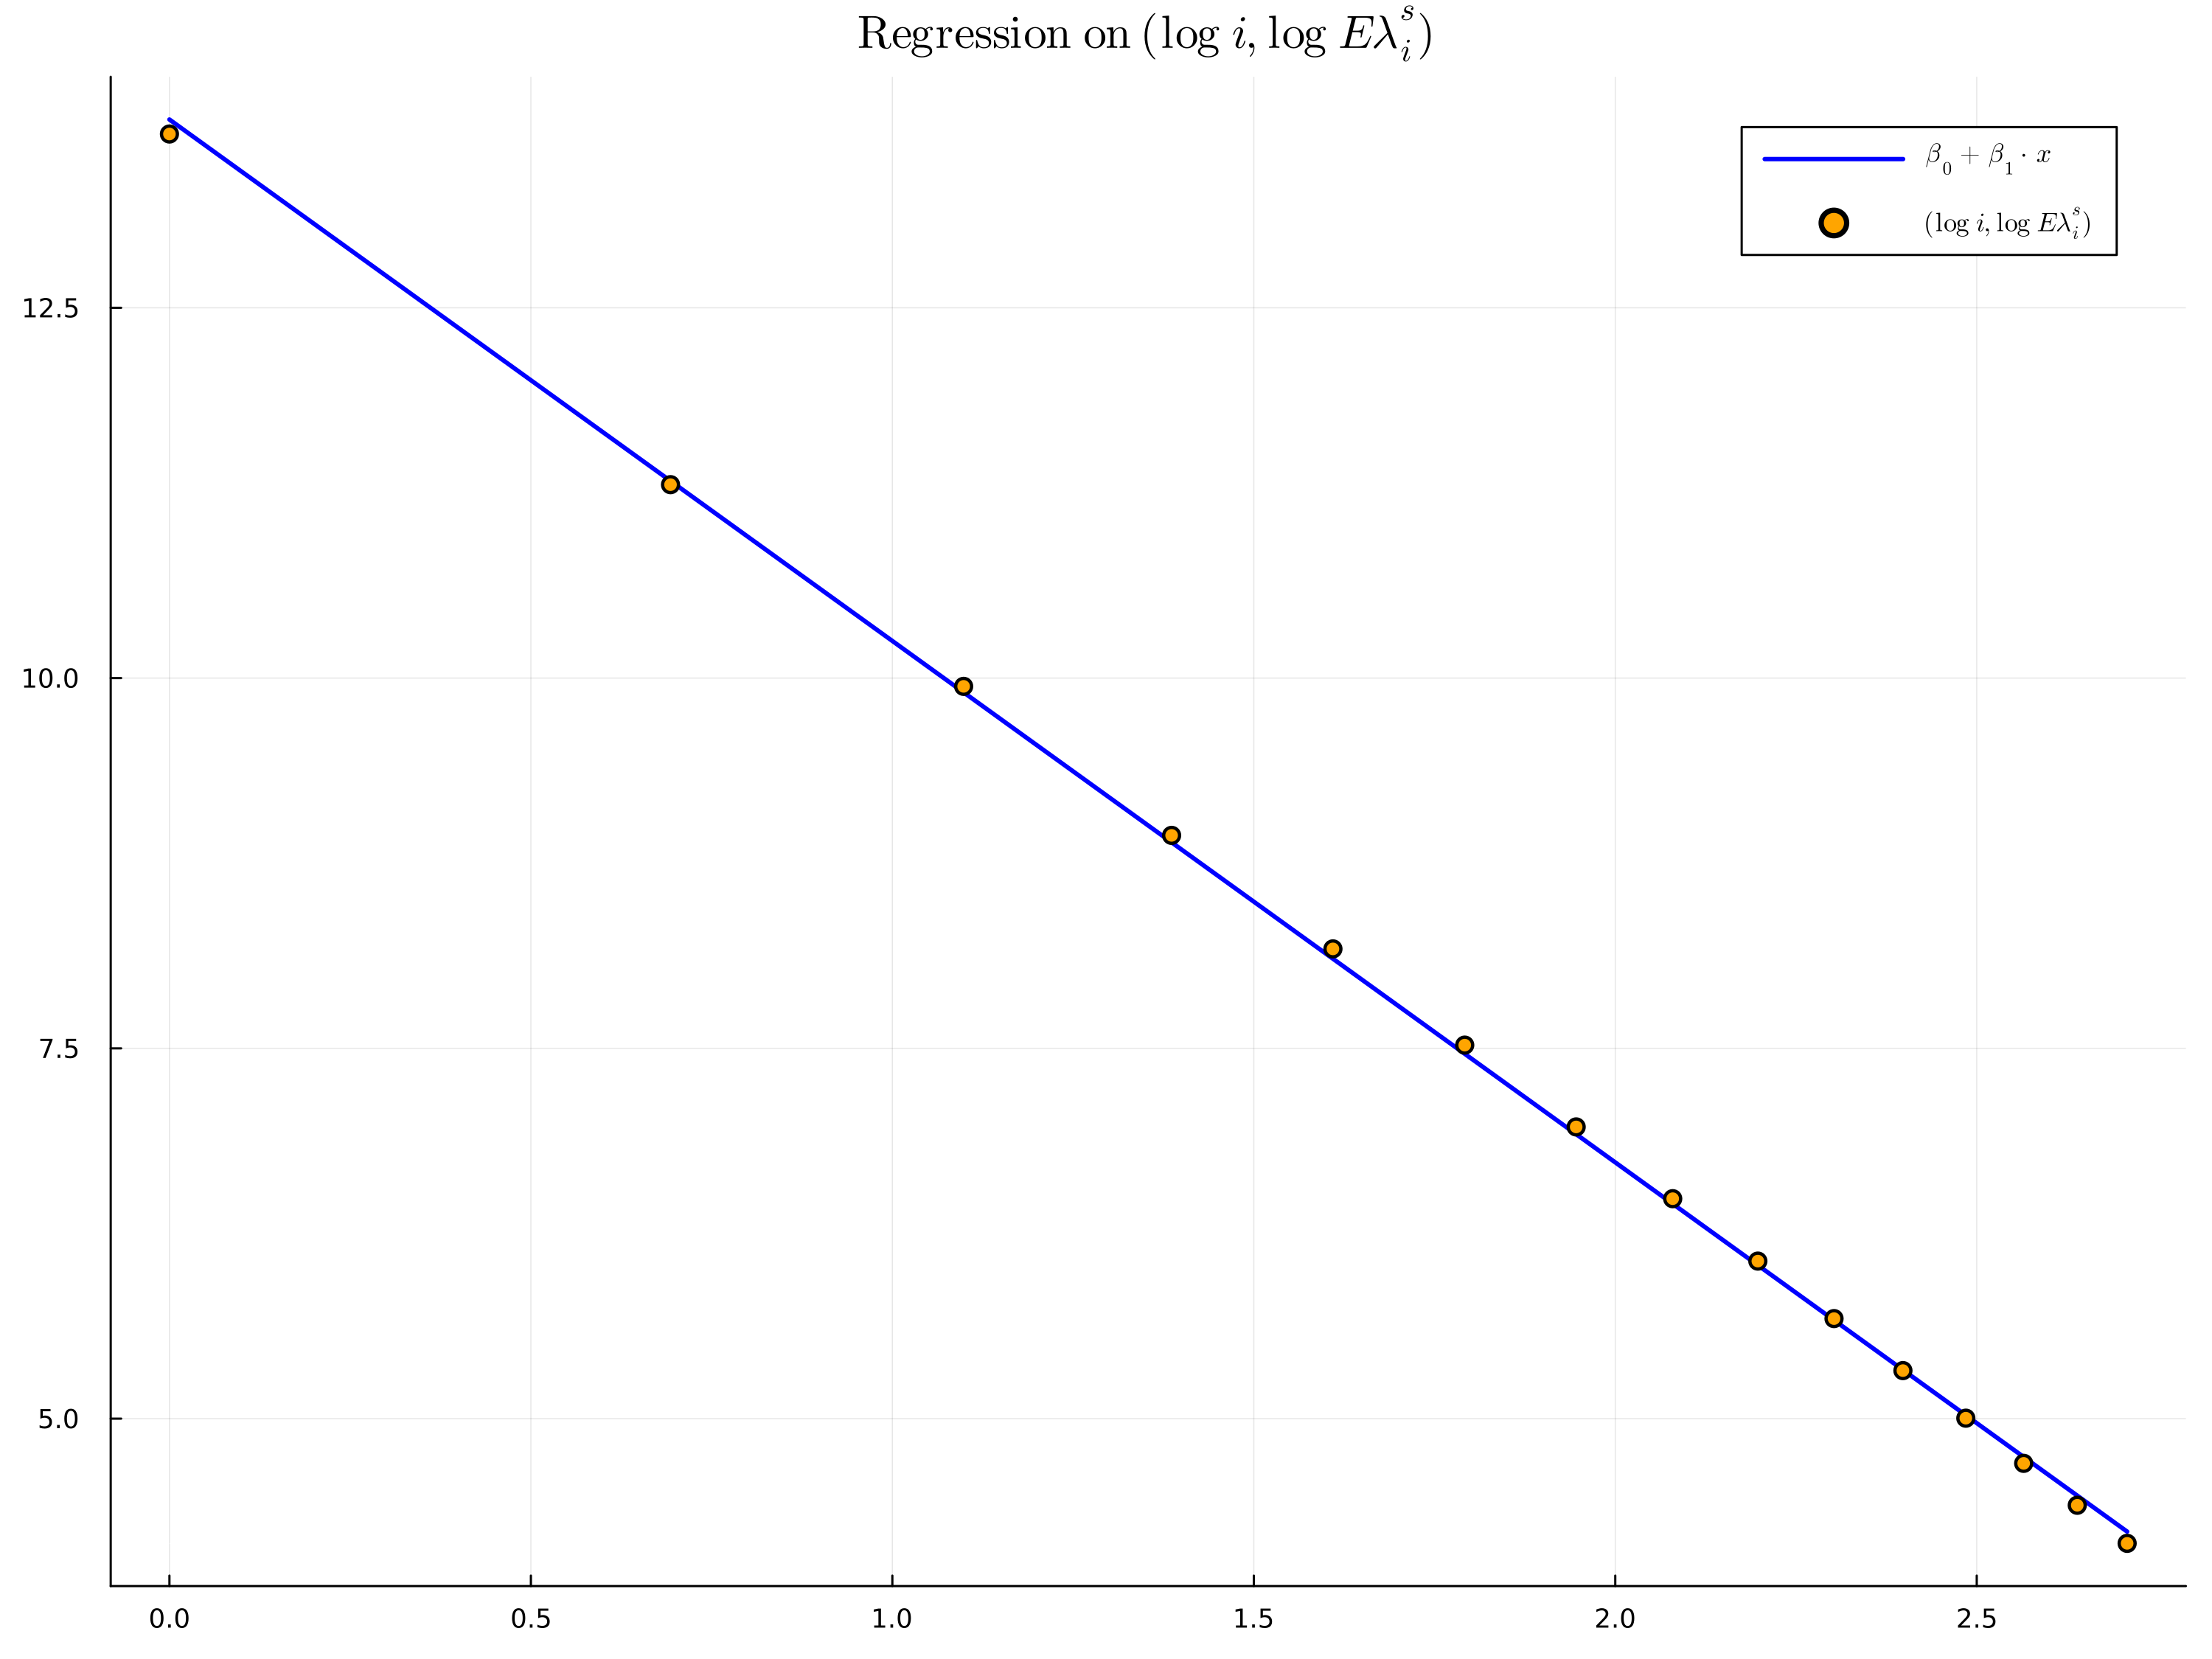

In [9]:
b0, b1 = coef(reg)[1], coef(reg)[2]     # extract regression intercept and slope
start_x, end_x = log(m0), log(m0+M-1)   # extract start and end of regression line too

# plot the scatter data and the regression line
x = range(start_x, end_x, length=1000)
y = @. b0 .+ b1 .* x
plot(x, y, label=L"\beta_0 + \beta_1 \cdot x", lw=2, lc=:blue, fmt = :png, dpi=300, size=(1000,750))
# next line: ugly hack for legend spacing
scatter!([minimum(log_ms)],[minimum(log_expectations)], label=" ", ms=0, mc=:white, msc=:white) 
plot!(log_ms, log_expectations, seriestype=:scatter, label=L"(\log\ i, \log\ E \lambda_i^s)", c=:orange)
title!(L"\mathrm{Regression\ on\ } (\log\ i, \log\ E \lambda_i^s)")

## Third case: 1000 samples for $\alpha=4, N=5000$

Same as before, but with $N=1000$. While the file contains 10000 samples, we only look at 1000 for the sake of comparison.

In [10]:
# NOTE: in Julia array indexing starts at 1

alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 1000                                     # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 15                                       # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×15 Matrix{Float64}:
 0.00914148  0.0142135   0.0298502  …  0.428339  0.450333  0.524116
 0.0106539   0.016576    0.0282706     0.422732  0.514351  0.558042
 0.00897166  0.015927    0.0399726     0.426652  0.514846  0.538707
 0.00207322  0.0188935   0.0318698     0.47682   0.52961   0.631166
 0.0208934   0.031806    0.0409756     0.490729  0.55995   0.6504
 0.0136106   0.0207241   0.0691526  …  0.509926  0.556284  0.653349
 0.0118813   0.0171073   0.033288      0.522285  0.554535  0.594456
 0.0071376   0.0164402   0.0398466     0.482865  0.559578  0.607871
 0.0128186   0.0190013   0.036874      0.473362  0.532385  0.607894
 0.00309684  0.0146676   0.0406249     0.474539  0.601026  0.657447
 0.009679    0.0294154   0.0472156  …  0.506851  0.592048  0.630638
 0.00819683  0.0147609   0.0478627     0.447108  0.537206  0.599684
 0.0128417   0.0194064   0.0412946     0.493156  0.594894  0.639825
 ⋮                                  ⋱                      
 0.0103483   0.0280716   0.052769

Same as before, nothing changes for the regression.

In [11]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  10.619     0.0340075   312.25    <1e-25   10.5455    10.6924
X            -3.54817   0.0169401  -209.45    <1e-23   -3.58477   -3.51158
──────────────────────────────────────────────────────────────────────────

R squared is: 0.9997037656394379


We plot the result below.

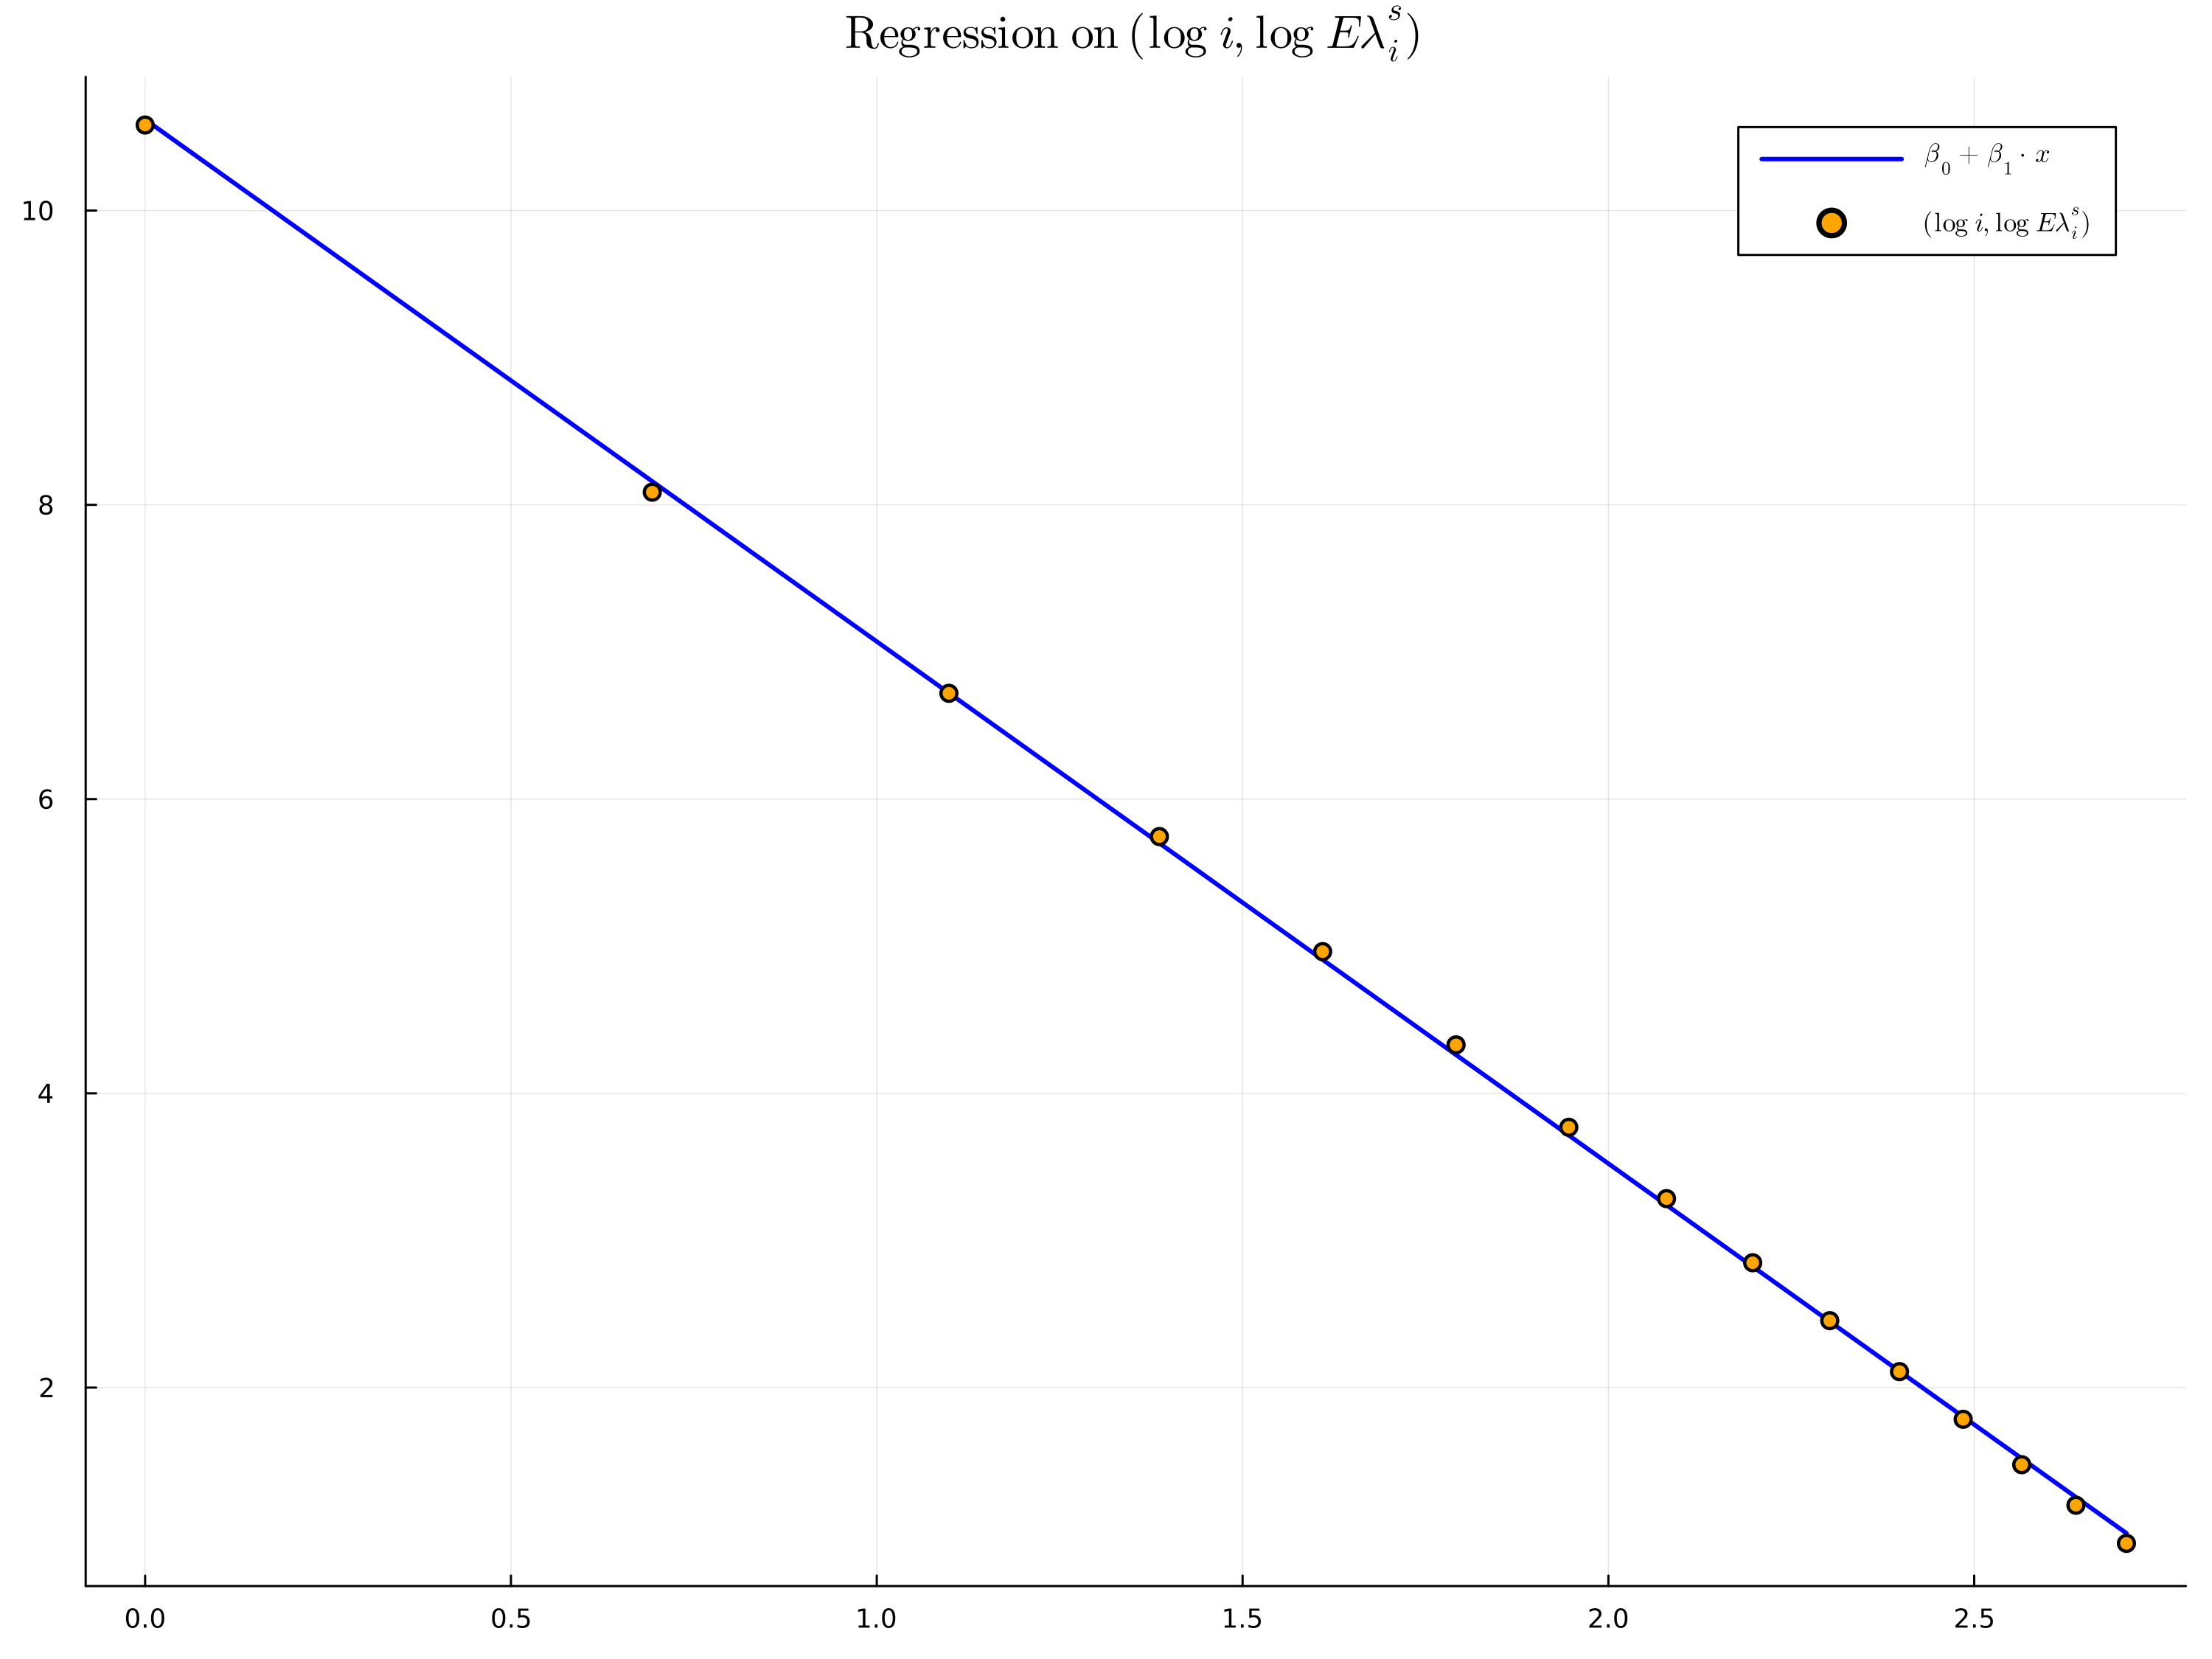

In [12]:
b0, b1 = coef(reg)[1], coef(reg)[2]     # extract regression intercept and slope
start_x, end_x = log(m0), log(m0+M-1)   # extract start and end of regression line too

# plot the scatter data and the regression line
x = range(start_x, end_x, length=1000)
y = @. b0 .+ b1 .* x
plot(x, y, label=L"\beta_0 + \beta_1 \cdot x", lw=2, lc=:blue, fmt = :png, dpi=300, size=(1000,750))
# next line: ugly hack for legend spacing
scatter!([minimum(log_ms)],[minimum(log_expectations)], label=" ", ms=0, mc=:white, msc=:white) 
plot!(log_ms, log_expectations, seriestype=:scatter, label=L"(\log\ i, \log\ E \lambda_i^s)", c=:orange)
title!(L"\mathrm{Regression\ on\ } (\log\ i, \log\ E \lambda_i^s)")

## Concluding remarks I: on the previous three cases

- in all cases we have looked at $1000$ iid samples for consistency, for matrix sizes $N \in \{10000, 5000, 1000\}$ and for $\alpha=4$
- in all cases we fitted a linear model $y = \beta_0 + \beta_1 \cdot x$ on $(\log i, \log E \lambda_i^s)$ for $i=1, \dots, 15$, $s=-2$
- the $R^2$ coefficient doesn't seem to change much as we decrease matrix size; the relation looks solidly linear throughout
    - $N=10000, R^2 = 0.9996715306706269$
    - $N=5000, R^2 = 0.9996302367539628$
    - $N=1000, R^2 = 0.9997037656394379$
- the $p$-values ```Pr(>|t|)``` for the intercept and the linear coefficient remain *very low* throughout
- the linear coefficient $\beta_1$ changes a bit as we decrease $N$:
    - $N=10000, \beta_1 = -3.53214$
    - $N=5000, \beta_1 = -3.52061$
    - $N=1000, \beta_1 = -3.54817$
- the intercept $\beta_0$ changes a lot:
    - $N=10000, \beta_0 = 15.1817$
    - $N=5000, \beta_0 = 13.7713$
    - $N=1000, \beta_0 = 10.619$
    
Here is the full summary in all three cases:

- $N=10000$

    > ```
    > Coefficients:
    > ──────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
    > ──────────────────────────────────────────────────────────────────────────
    > (Intercept)  15.1817    0.0356488   425.87    <1e-27   15.1047    15.2587
    > X            -3.53214   0.0177576  -198.91    <1e-23   -3.57051   -3.49378
    > ──────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9996715306706269
    > ```

- $N=5000$

    > ```
    > Coefficients:
    > ──────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
    > ──────────────────────────────────────────────────────────────────────────
    > (Intercept)  13.7713    0.0377006   365.28    <1e-26   13.6898    13.8527
    > X            -3.52061   0.0187797  -187.47    <1e-22   -3.56118   -3.48004
    > ──────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9996302367539628
    > ```

- $N=1000$

    > ```
    > Coefficients:
    > ──────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
    > ──────────────────────────────────────────────────────────────────────────
    > (Intercept)  10.619     0.0340075   312.25    <1e-25   10.5455    10.6924
    > X            -3.54817   0.0169401  -209.45    <1e-23   -3.58477   -3.51158
    > ──────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9997037656394379
    > ```

## Regressing a large number of points, $\alpha=4, N=10000$

So far we've tried to do linear regression on the first $M=15$ data points. Let us try doing it with $M=100, 1000, 5000, 7500, 9000, 10000$ (yes, the last one contains *all the points*). We first set up the data, and start with $M=100$.

In [13]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 100                                      # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×100 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  2.3745   2.40546  2.4536   2.51932
 0.000779669  0.00120705   0.00350779     2.43605  2.49222  2.53785  2.55643
 0.000400754  0.000852894  0.00203974     2.41324  2.41624  2.45149  2.48765
 0.000652653  0.00313822   0.00455475     2.40212  2.43151  2.48861  2.53542
 0.000401578  0.00102299   0.00279176     2.36309  2.40499  2.4554   2.53352
 0.000591167  0.00114146   0.00497109  …  2.30991  2.3758   2.4171   2.49863
 0.0014827    0.00237106   0.00476994     2.4288   2.46218  2.50251  2.57275
 0.000964205  0.00234669   0.0045921      2.38792  2.4346   2.50985  2.55921
 0.000773585  0.00163975   0.0034974      2.4143   2.42775  2.48851  2.55003
 0.00111742   0.00230499   0.00401473     2.37577  2.41408  2.4604   2.52171
 0.00127158   0.00217043   0.00601826  …  2.33647  2.37652  2.44401  2.48186
 0.000903169  0.00180299   0.00408361     2.4023   2.42193  2.47424  2.52064
 0.00108514   0.00306227   0.00422113     2.34795 

We use the same value of $s$ as before.

In [14]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  15.6609    0.0392672   398.83    <1e-99   15.583     15.7388
X            -3.78074   0.0104635  -361.33    <1e-99   -3.80151   -3.75998
──────────────────────────────────────────────────────────────────────────

R squared is: 0.9992499318603848


Now we try $M=1000$. 

In [15]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 1000                                     # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×1000 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  245.995  246.773  247.222  247.632
 0.000779669  0.00120705   0.00350779     246.274  247.103  247.409  247.519
 0.000400754  0.000852894  0.00203974     246.294  246.629  247.132  247.242
 0.000652653  0.00313822   0.00455475     246.014  246.371  246.717  247.143
 0.000401578  0.00102299   0.00279176     246.176  246.775  247.262  248.28
 0.000591167  0.00114146   0.00497109  …  246.472  246.904  247.273  247.644
 0.0014827    0.00237106   0.00476994     246.693  247.267  247.63   248.012
 0.000964205  0.00234669   0.0045921      245.993  246.618  246.976  247.628
 0.000773585  0.00163975   0.0034974      246.341  246.777  247.089  247.696
 0.00111742   0.00230499   0.00401473     245.976  246.367  246.881  247.575
 0.00127158   0.00217043   0.00601826  …  246.393  246.859  247.196  247.447
 0.000903169  0.00180299   0.00408361     246.106  246.633  247.159  247.654
 0.00108514   0.00306227   0.00422113     245.894 

Same parameters as always.

In [16]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  16.2556   0.0119579    1359.39    <1e-99   16.2321    16.279
X            -3.94368  0.00199511  -1976.67    <1e-99   -3.94759   -3.93976
───────────────────────────────────────────────────────────────────────────

R squared is: 0.9997446406326693


Finally, $M=5000$.

In [17]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 5000                                     # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×5000 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  6520.98  6524.82  6526.37  6527.84
 0.000779669  0.00120705   0.00350779     6522.85  6526.74  6527.67  6531.26
 0.000400754  0.000852894  0.00203974     6522.31  6523.28  6526.1   6529.78
 0.000652653  0.00313822   0.00455475     6522.9   6525.74  6528.33  6530.2
 0.000401578  0.00102299   0.00279176     6523.67  6525.08  6529.25  6530.3
 0.000591167  0.00114146   0.00497109  …  6526.5   6528.45  6530.6   6532.62
 0.0014827    0.00237106   0.00476994     6524.57  6527.72  6531.41  6533.89
 0.000964205  0.00234669   0.0045921      6521.64  6522.91  6527.44  6529.79
 0.000773585  0.00163975   0.0034974      6521.84  6523.73  6525.37  6529.05
 0.00111742   0.00230499   0.00401473     6521.72  6523.87  6526.13  6529.41
 0.00127158   0.00217043   0.00601826  …  6516.16  6520.08  6523.32  6525.58
 0.000903169  0.00180299   0.00408361     6522.94  6524.14  6526.97  6530.33
 0.00108514   0.00306227   0.00422113     6518.54  

Same parameters as before.

In [18]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  16.6148   0.00504314    3294.53    <1e-99   16.6049    16.6247
X            -4.00567  0.000664983  -6023.72    <1e-99   -4.00697   -4.00437
────────────────────────────────────────────────────────────────────────────

R squared is: 0.9998622769202816


Now onto  $M=7500$.

In [19]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 7500                                     # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×7500 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  16096.2  16099.9  16105.9  16109.3
 0.000779669  0.00120705   0.00350779     16098.5  16104.8  16111.8  16115.1
 0.000400754  0.000852894  0.00203974     16103.0  16108.3  16114.9  16118.4
 0.000652653  0.00313822   0.00455475     16103.9  16105.1  16109.0  16114.2
 0.000401578  0.00102299   0.00279176     16105.0  16108.1  16110.1  16116.3
 0.000591167  0.00114146   0.00497109  …  16096.3  16103.8  16105.4  16118.5
 0.0014827    0.00237106   0.00476994     16110.1  16113.4  16119.6  16123.5
 0.000964205  0.00234669   0.0045921      16100.2  16103.1  16107.2  16114.8
 0.000773585  0.00163975   0.0034974      16099.8  16104.0  16106.8  16113.7
 0.00111742   0.00230499   0.00401473     16102.3  16111.0  16112.4  16115.4
 0.00127158   0.00217043   0.00601826  …  16097.8  16105.2  16107.2  16109.7
 0.000903169  0.00180299   0.00408361     16097.3  16102.9  16106.5  16111.2
 0.00108514   0.00306227   0.00422113     16107.5

Same $s$ as always.

In [20]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  16.8959   0.00677897    2492.40    <1e-99   16.8827    16.9092
X            -4.04728  0.000848875  -4767.82    <1e-99   -4.04895   -4.04562
────────────────────────────────────────────────────────────────────────────

R squared is: 0.9996702668461551


Second to last: $M=9000$.

In [21]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 9000                                     # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×9000 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  25922.1  25926.3  25929.8  25943.2
 0.000779669  0.00120705   0.00350779     25919.2  25935.3  25941.9  25951.4
 0.000400754  0.000852894  0.00203974     25936.0  25940.8  25946.3  25950.8
 0.000652653  0.00313822   0.00455475     25929.9  25938.4  25947.7  25951.9
 0.000401578  0.00102299   0.00279176     25922.0  25926.9  25937.4  25942.1
 0.000591167  0.00114146   0.00497109  …  25922.6  25934.6  25938.5  25950.4
 0.0014827    0.00237106   0.00476994     25932.2  25940.1  25953.2  25961.0
 0.000964205  0.00234669   0.0045921      25918.0  25928.1  25931.6  25940.9
 0.000773585  0.00163975   0.0034974      25925.7  25937.3  25943.1  25949.1
 0.00111742   0.00230499   0.00401473     25924.4  25928.5  25939.9  25947.5
 0.00127158   0.00217043   0.00601826  …  25919.1  25926.9  25941.7  25948.2
 0.000903169  0.00180299   0.00408361     25916.3  25923.0  25932.1  25944.0
 0.00108514   0.00306227   0.00422113     25924.9

Same $s$.

In [22]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  17.1713   0.00964025   1781.21    <1e-99   17.1524    17.1902
X            -4.08646  0.00118043  -3461.83    <1e-99   -4.08877   -4.08415
───────────────────────────────────────────────────────────────────────────

R squared is: 0.9992497462934117


Finally, $M=10000$. We use *all data points*.

In [23]:
alpha_str = "4.00"
alpha = parse(Float64, alpha_str)            # alpha-1 is the Laguerre parameter, alpha > 0

# below: in general N * num_samples = 10^7 = 10 000 000 (i.e., each file contains 10 milion numbers)
N = 10000                                    # matrix size
num_samples = 1000                           # number of samples, each sample is a line

m0 = 1                                       # where to start with the linear regression
M = 10000                                    # we stop at m0 + M

range_ms = m0 : m0 + M - 1                   # the range

# each row of A contains an independent sample
A = readdlm(string("LUE_N_", N,"_alpha_", alpha_str, ".txt"), '\t', Float64, '\n')[1:num_samples, range_ms]

1000×10000 Matrix{Float64}:
 0.000337333  0.00259883   0.0047951   …  39681.5  39742.9  39894.7  39943.3
 0.000779669  0.00120705   0.00350779     39627.4  39701.5  39740.1  39819.1
 0.000400754  0.000852894  0.00203974     39718.4  39748.0  39808.3  39955.8
 0.000652653  0.00313822   0.00455475     39666.3  39706.0  39828.1  39963.1
 0.000401578  0.00102299   0.00279176     39669.8  39689.1  39735.0  39846.2
 0.000591167  0.00114146   0.00497109  …  39638.1  39742.7  39829.7  39896.7
 0.0014827    0.00237106   0.00476994     39646.9  39728.4  39769.3  39924.1
 0.000964205  0.00234669   0.0045921      39686.2  39720.3  39834.0  39928.8
 0.000773585  0.00163975   0.0034974      39713.1  39744.8  39858.9  39962.7
 0.00111742   0.00230499   0.00401473     39682.7  39759.9  39885.7  39940.2
 0.00127158   0.00217043   0.00601826  …  39678.9  39746.4  39853.1  39932.3
 0.000903169  0.00180299   0.00408361     39608.1  39691.0  39756.8  39848.2
 0.00108514   0.00306227   0.00422113     39676.

In [24]:
s = -2.0
# log_expectations = [log( sum( (A[:, m - m0 + 1] .^ s) ./ num_samples ) ) for m in range_ms];
log_expectations = [log(mean(A[:, m - m0 + 1] .^ s)) for m in range_ms];
log_ms = [log(m) for m in range_ms];
    
# setting up the DataFrame and the linear model
data = DataFrame(X=log_ms, Y=log_expectations)
reg = lm(@formula(Y ~ X), data)

display(reg)

println("R squared is: ", r2(reg))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  17.4729    0.013851    1261.49    <1e-99   17.4458    17.5001
X            -4.12853   0.0016746  -2465.39    <1e-99   -4.13182   -4.12525
───────────────────────────────────────────────────────────────────────────

R squared is: 0.9983577899394526


## Concluding remarks II: regressing more and more points

The relation remains stubbornly linear, with some decrease in $R^2$ only when we approach the soft-edge (i.e. when we include the last few hundred eigenvalues). 

Before we list the summary, recall we have used $N=10000$ as our matrix size (number of eigenvalues), used 1000 iid samples, and used $\alpha=4, s=-2$. Second, we have regressed 

$$(\log i, \log E \lambda_i^s)$$

for $1 \leq i \leq M$, and for $M = 100, 1000, 5000, 7500, 9000, 10000$. We notice that regressing the first half of the eigenvalues gives *the best* $R^2$ so far. 

The summary is as follows:

- $M=100$

    > ```
    > Coefficients:
    > ──────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
    > ──────────────────────────────────────────────────────────────────────────
    > (Intercept)  15.6609    0.0392672   398.83    <1e-99   15.583     15.7388
    > X            -3.78074   0.0104635  -361.33    <1e-99   -3.80151   -3.75998
    > ──────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9992499318603848
    > ```
    
- $M=1000$

    > ```
    > Coefficients:
    > ───────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
    > ───────────────────────────────────────────────────────────────────────────
    > (Intercept)  16.2556   0.0119579    1359.39    <1e-99   16.2321    16.279
    > X            -3.94368  0.00199511  -1976.67    <1e-99   -3.94759   -3.93976
    > ───────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9997446406326693
    > ```
    
- $M=5000$

    > ```
    > Coefficients:
    > ────────────────────────────────────────────────────────────────────────────
    >                 Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
    > ────────────────────────────────────────────────────────────────────────────
    > (Intercept)  16.6148   0.00504314    3294.53    <1e-99   16.6049    16.6247
    > X            -4.00567  0.000664983  -6023.72    <1e-99   -4.00697   -4.00437
    > ────────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9998622769202816
    > ```
    
- $M=7500$

    > ```
    > Coefficients:
    > ────────────────────────────────────────────────────────────────────────────
    >                 Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
    > ────────────────────────────────────────────────────────────────────────────
    > (Intercept)  16.8959   0.00677897    2492.40    <1e-99   16.8827    16.9092
    > X            -4.04728  0.000848875  -4767.82    <1e-99   -4.04895   -4.04562
    > ────────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9996702668461551
    > ```
    
- $M=9000$

    > ```
    > Coefficients:
    > ───────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
    > ───────────────────────────────────────────────────────────────────────────
    > (Intercept)  17.1713   0.00964025   1781.21    <1e-99   17.1524    17.1902
    > X            -4.08646  0.00118043  -3461.83    <1e-99   -4.08877   -4.08415
    > ───────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9992497462934117
    > ```
    
- $M=10000$

    > ```
    > Coefficients:
    > ───────────────────────────────────────────────────────────────────────────
    >                 Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
    > ───────────────────────────────────────────────────────────────────────────
    > (Intercept)  17.4729    0.013851    1261.49    <1e-99   17.4458    17.5001
    > X            -4.12853   0.0016746  -2465.39    <1e-99   -4.13182   -4.12525
    > ───────────────────────────────────────────────────────────────────────────
    > R squared is: 0.9983577899394526
    > ```